In [1]:
import os 
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
print(len(os.listdir("D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/Keratoconus")),len(os.listdir("D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/Normal")))

1050 1050


In [4]:
k_count=len(os.listdir("D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/Keratoconus"))
n_count=len(os.listdir("D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/Normal"))

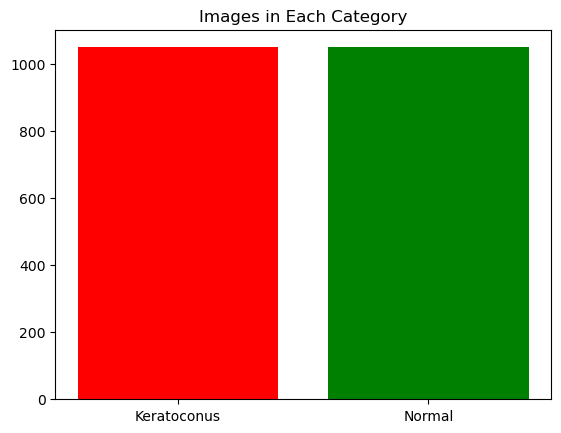

In [5]:
categories=["Keratoconus","Normal"]
counts=[k_count,n_count]
plt.bar(categories,counts,color=["red","green"])
plt.xlabel=('categories')
plt.ylabes=('Number of Images')
plt.title('Images in Each Category')
plt.show()

In [7]:
import splitfolders
import pathlib

base_dir="D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets"
base_dir=pathlib.Path(base_dir)
img_height=224
img_width=224
batch_size=32
output_path="D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/split"

splitfolders.ratio(base_dir,output=output_path,seed=1337,ratio=(.8,.1,.1),group_prefix=None)

Copying files: 2100 files [00:09, 211.41 files/s]


In [6]:
train_dir="D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/split/train"
val_dir="D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/split/val"
test_dir="D:/Project/Datasets/Keratocunus/archive-k1/Train_Validation sets/split/test"
img_size=(224,224)
batch_size=32

In [9]:
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout,Input,Lambda, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from skimage import exposure, filters
from skimage.restoration import denoise_tv_chambolle
from keras.optimizers import Adam
from keras import regularizers
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [10]:
data_gen=ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            zoom_range=0.15,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_generator=data_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

validation_generator = data_gen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)
test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 1680 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 210 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'Keratoconus': 0, 'Normal': 1}

In [13]:
model=Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='sigmoid'))

In [14]:
optimizer = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 111, 111, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                      

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=int(round(1680/32)),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=int(round(210/32))
)

Epoch 1/30
52/52 [==============================] - 74s 1s/step - loss: 7.6430 - accuracy: 0.7561 - val_loss: 6.4446 - val_accuracy: 0.5000
Epoch 2/30
52/52 [==============================] - 60s 1s/step - loss: 4.7435 - accuracy: 0.7992 - val_loss: 4.2107 - val_accuracy: 0.5000
Epoch 3/30
52/52 [==============================] - 57s 1s/step - loss: 3.1356 - accuracy: 0.8210 - val_loss: 3.3223 - val_accuracy: 0.5048
Epoch 4/30
52/52 [==============================] - 51s 982ms/step - loss: 2.6513 - accuracy: 0.8380 - val_loss: 3.0002 - val_accuracy: 0.5048
Epoch 5/30
52/52 [==============================] - 54s 1s/step - loss: 2.2243 - accuracy: 0.8483 - val_loss: 2.2639 - val_accuracy: 0.6190
Epoch 6/30
52/52 [==============================] - 55s 1s/step - loss: 2.0132 - accuracy: 0.8441 - val_loss: 1.9966 - val_accuracy: 0.7952
Epoch 7/30
52/52 [==============================] - 56s 1s/step - loss: 1.7011 - accuracy: 0.8726 - val_loss: 1.6381 - val_accuracy: 0.7952
Epoch 8/30
52/52 

In [18]:
from tensorflow.keras.models import save_model
model_path='D:/Project/ML/Keratoconus_detection1.h5'
save_model(model,model_path)

C:\Users\prath\AppData\Local\Temp\ipykernel_49248\3755841181.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,model_path)


TypeError: 'str' object is not callable

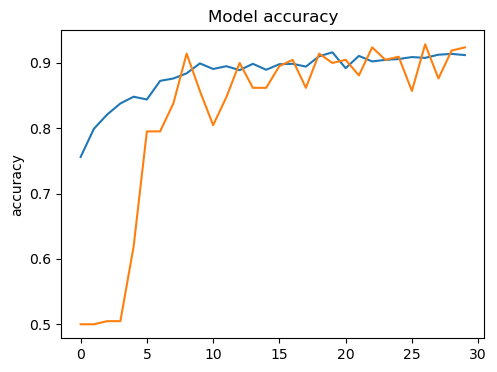

In [19]:
def plot_train_history(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.show()
plot_train_history(history)

In [20]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import numpy as np
loaded_model=load_model('D:/Project/ML/Keratoconus_detection1.h5')
print("Keratoconus Detection Model Loaded")
def keratoconus_prediction(test_image_path):
    test_image = load_img(test_image_path, target_size=(224, 224))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    predictions = loaded_model.predict(test_image)

    # Assuming the model outputs a single prediction value (0 or 1) directly
    predicted_class = np.argmax(predictions[0])
    
    if predicted_class == 1:
        print("Normal")
    elif predicted_class==0:
        print("Keratoconus")
    
    return predicted_class

Keratoconus Detection Model Loaded


In [21]:
evaluation = model.evaluate(test_generator)
accuracy = evaluation[1]
print(f"Validation Accuracy: {accuracy}")

7/7 [==============================] - 3s 459ms/step - loss: 0.4611 - accuracy: 0.9048
Validation Accuracy: 0.9047619104385376
